In [1]:
import pandas as pd
import csv
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.model_selection import cross_val_score

In [2]:
ericsson = pd.read_csv("data/ericsson_lte_cell_data.csv")
nsn = pd.read_csv("data/nsn_lte_cell_data.csv")

In [3]:
ericsson.head()

,Unnamed: 0,active_ue_dl_4g,active_ue_ul_4g,connected_user_avg,connected_user_max,country_short,cqi_avg_4g,date,duration_ul_s_4g,cell_id_hashed,...,ps_ul_mb,site_id_hashed,system,transferred_data_ul_mb_4g,z1_4g_suc_att_erab,z2_4g_sim_active_ue_dl,technology,brand,underdimensioned_hour,throughput_mbit_per_second_per_user
0,0,0.000015,0.000079,0.001389,1.0,SE,NaN,4/21/2020,0.0,4962646669732964403,...,0.01,-9123333802924409698,LTE2600,0.0,1.0,0.947368,4g,ericsson,1,4.199219
1,1,0.000473,0.000729,0.036111,2.0,SE,NaN,4/21/2020,0.0,4962646669732964403,...,0.18,-9123333802924409698,LTE2600,0.0,8.0,0.993003,4g,ericsson,0,66.675159
2,2,0.000000,0.000000,0.000000,0.0,SE,NaN,4/21/2020,0.0,4962646669732964403,...,0.00,-9123333802924409698,LTE2600,0.0,0.0,NaN,4g,ericsson,0,0.000000
3,3,0.000000,0.000000,0.000000,0.0,SE,NaN,4/21/2020,0.0,4962646669732964403,...,0.00,-9123333802924409698,LTE2600,0.0,0.0,NaN,4g,ericsson,0,0.000000
4,4,0.000000,0.000000,0.000000,0.0,SE,NaN,4/21/2020,0.0,4962646669732964403,...,0.00,-9123333802924409698,LTE2600,0.0,0.0,NaN,4g,ericsson,0,0.000000


Now, check if the 'underdimensioned_hour' and 'throughput_mbit_per_second_per_user' have any NaN values since they are crucial labels for this task.

In [4]:
print(ericsson['underdimensioned_hour'].isnull().sum())
print(ericsson['throughput_mbit_per_second_per_user'].isnull().sum())

0
0


There are some cases where both of 'underdimensioned_hour' and 'throughput_mbit_per_second_per_user'are equal to 0.

I consider these samples as 'dirty' samples, so cut them off.

In [5]:
temp1 = ericsson[(ericsson.throughput_mbit_per_second_per_user != 0) & (ericsson.underdimensioned_hour != 0)
                |(ericsson.throughput_mbit_per_second_per_user != 0) & (ericsson.underdimensioned_hour == 0)
                |(ericsson.throughput_mbit_per_second_per_user == 0) & (ericsson.underdimensioned_hour != 0)]
print(temp1.shape)

(2037164, 29)


Check if there are more than one unique value in the columns 'country_short', 'municipality', 'municipality_code', 'technology', 'brand' 

In [6]:
print(ericsson['country_short'].unique())
print(ericsson['municipality'].unique())
print(ericsson['municipality_code'].unique())
print(ericsson['technology'].unique())
print(ericsson['brand'].unique())

['SE']
['STOCKHOLM']
[180]
['4g']
['ericsson']


Since these features only have a single value for each, we can throw them away and also the ID column.

In [7]:
temp1 = temp1.drop(['Unnamed: 0','country_short','municipality', 'municipality_code', 'technology', 'brand'], axis = 1)
temp1

,active_ue_dl_4g,active_ue_ul_4g,connected_user_avg,connected_user_max,cqi_avg_4g,date,duration_ul_s_4g,cell_id_hashed,hour,prb_dl_utilization_4g,...,ps_dl_mb,ps_drop_ratio,ps_ul_mb,site_id_hashed,system,transferred_data_ul_mb_4g,z1_4g_suc_att_erab,z2_4g_sim_active_ue_dl,underdimensioned_hour,throughput_mbit_per_second_per_user
0,0.000015,0.000079,0.001389,1.0,NaN,4/21/2020,0.0,4962646669732964403,0,0.645609,...,0.01,NaN,0.01,-9123333802924409698,LTE2600,0.0,1.0,0.947368,1,4.199219
1,0.000473,0.000729,0.036111,2.0,NaN,4/21/2020,0.0,4962646669732964403,1,0.679367,...,7.65,0.000000,0.18,-9123333802924409698,LTE2600,0.0,8.0,0.993003,0,66.675159
6,0.000781,0.001492,0.147222,2.0,NaN,4/21/2020,0.0,4962646669732964403,6,1.016763,...,3.47,0.000000,0.48,-9123333802924409698,LTE2600,0.0,17.0,0.998935,0,19.384058
7,0.008470,0.013564,0.684722,6.0,NaN,4/21/2020,10.0,4962646669732964403,7,2.148440,...,93.15,0.000000,5.12,-9123333802924409698,LTE2600,14.0,125.0,1.016671,0,52.889153
8,0.004484,0.011153,0.352778,6.0,NaN,4/21/2020,21.0,4962646669732964403,8,1.264922,...,44.30,0.000000,26.21,-9123333802924409698,LTE2600,196.0,68.0,1.001365,0,85.408606
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2339741,0.347333,0.315068,34.368056,51.0,10.622132,4/16/2020,117.0,-7494143389083077097,19,19.935923,...,3144.04,0.077042,267.63,4805625006409153234,LTE1800,1095.0,9192.0,1.181464,0,38.668383
2339742,0.352972,0.386087,33.150000,50.0,10.599167,4/16/2020,121.0,-7494143389083077097,20,19.474488,...,3430.15,0.088300,194.65,4805625006409153234,LTE1800,224.0,9097.0,1.219010,0,43.577573
2339743,0.257978,0.277671,32.644444,47.0,10.640825,4/16/2020,82.0,-7494143389083077097,21,14.548356,...,2498.64,0.060599,125.03,4805625006409153234,LTE1800,211.0,8287.0,1.164011,0,46.106332
2339744,0.251979,0.236201,30.475000,48.0,10.519431,4/16/2020,53.0,-7494143389083077097,22,13.955182,...,2395.40,0.027159,126.23,4805625006409153234,LTE1800,190.0,7375.0,1.149335,0,55.500962


Also, I decided to not use the 'date' column since I believe there is no causality or correlation between the date and underdimensioning issue. The metric supposed to be used for making the investment decision is the number of hours that struggled with providing the enough throughput. I used one-hot encoding for the 'hour' and 'system' feature. 

In [8]:
temp1 = temp1.drop(['date'], axis = 1)
hour_dummies = pd.get_dummies(temp1.hour, prefix='hour')
system_dummies = pd.get_dummies(temp1.system, prefix='system')
temp1 = temp1.drop(['hour','system'], axis = 1)
temp1

,active_ue_dl_4g,active_ue_ul_4g,connected_user_avg,connected_user_max,cqi_avg_4g,duration_ul_s_4g,cell_id_hashed,prb_dl_utilization_4g,prb_ul_utilization_4g,ps_accessibility,ps_attempt,ps_dl_mb,ps_drop_ratio,ps_ul_mb,site_id_hashed,transferred_data_ul_mb_4g,z1_4g_suc_att_erab,z2_4g_sim_active_ue_dl,underdimensioned_hour,throughput_mbit_per_second_per_user
0,0.000015,0.000079,0.001389,1.0,NaN,0.0,4962646669732964403,0.645609,0.000321,100.000000,1.0,0.01,NaN,0.01,-9123333802924409698,0.0,1.0,0.947368,1,4.199219
1,0.000473,0.000729,0.036111,2.0,NaN,0.0,4962646669732964403,0.679367,0.004582,100.000000,8.0,7.65,0.000000,0.18,-9123333802924409698,0.0,8.0,0.993003,0,66.675159
6,0.000781,0.001492,0.147222,2.0,NaN,0.0,4962646669732964403,1.016763,0.024918,100.000000,17.0,3.47,0.000000,0.48,-9123333802924409698,0.0,17.0,0.998935,0,19.384058
7,0.008470,0.013564,0.684722,6.0,NaN,10.0,4962646669732964403,2.148440,0.121654,100.000000,124.0,93.15,0.000000,5.12,-9123333802924409698,14.0,125.0,1.016671,0,52.889153
8,0.004484,0.011153,0.352778,6.0,NaN,21.0,4962646669732964403,1.264922,0.391138,100.000000,66.0,44.30,0.000000,26.21,-9123333802924409698,196.0,68.0,1.001365,0,85.408606
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2339741,0.347333,0.315068,34.368056,51.0,10.622132,117.0,-7494143389083077097,19.935923,2.827319,100.000000,9115.0,3144.04,0.077042,267.63,4805625006409153234,1095.0,9192.0,1.181464,0,38.668383
2339742,0.352972,0.386087,33.150000,50.0,10.599167,121.0,-7494143389083077097,19.474488,2.988034,99.989009,9033.0,3430.15,0.088300,194.65,4805625006409153234,224.0,9097.0,1.219010,0,43.577573
2339743,0.257978,0.277671,32.644444,47.0,10.640825,82.0,-7494143389083077097,14.548356,2.463528,99.975872,8207.0,2498.64,0.060599,125.03,4805625006409153234,211.0,8287.0,1.164011,0,46.106332
2339744,0.251979,0.236201,30.475000,48.0,10.519431,53.0,-7494143389083077097,13.955182,2.207374,100.000000,7337.0,2395.40,0.027159,126.23,4805625006409153234,190.0,7375.0,1.149335,0,55.500962


In [9]:
temp2 = pd.concat([temp1, hour_dummies, system_dummies], axis=1)
temp2

,active_ue_dl_4g,active_ue_ul_4g,connected_user_avg,connected_user_max,cqi_avg_4g,duration_ul_s_4g,cell_id_hashed,prb_dl_utilization_4g,prb_ul_utilization_4g,ps_accessibility,...,hour_18,hour_19,hour_20,hour_21,hour_22,hour_23,system_LTE1800,system_LTE2600,system_LTE700,system_LTE800
0,0.000015,0.000079,0.001389,1.0,NaN,0.0,4962646669732964403,0.645609,0.000321,100.000000,...,0,0,0,0,0,0,0,1,0,0
1,0.000473,0.000729,0.036111,2.0,NaN,0.0,4962646669732964403,0.679367,0.004582,100.000000,...,0,0,0,0,0,0,0,1,0,0
6,0.000781,0.001492,0.147222,2.0,NaN,0.0,4962646669732964403,1.016763,0.024918,100.000000,...,0,0,0,0,0,0,0,1,0,0
7,0.008470,0.013564,0.684722,6.0,NaN,10.0,4962646669732964403,2.148440,0.121654,100.000000,...,0,0,0,0,0,0,0,1,0,0
8,0.004484,0.011153,0.352778,6.0,NaN,21.0,4962646669732964403,1.264922,0.391138,100.000000,...,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2339741,0.347333,0.315068,34.368056,51.0,10.622132,117.0,-7494143389083077097,19.935923,2.827319,100.000000,...,0,1,0,0,0,0,1,0,0,0
2339742,0.352972,0.386087,33.150000,50.0,10.599167,121.0,-7494143389083077097,19.474488,2.988034,99.989009,...,0,0,1,0,0,0,1,0,0,0
2339743,0.257978,0.277671,32.644444,47.0,10.640825,82.0,-7494143389083077097,14.548356,2.463528,99.975872,...,0,0,0,1,0,0,1,0,0,0
2339744,0.251979,0.236201,30.475000,48.0,10.519431,53.0,-7494143389083077097,13.955182,2.207374,100.000000,...,0,0,0,0,1,0,1,0,0,0


Check which features need to be further preprocessed!

In [10]:
print(temp2.isnull().sum())

active_ue_dl_4g                             0
active_ue_ul_4g                             0
connected_user_avg                          0
connected_user_max                          0
cqi_avg_4g                             929810
duration_ul_s_4g                            0
cell_id_hashed                              0
prb_dl_utilization_4g                       8
prb_ul_utilization_4g                       8
ps_accessibility                        11473
ps_attempt                                  0
ps_dl_mb                                    0
ps_drop_ratio                            8774
ps_ul_mb                                    0
site_id_hashed                              0
transferred_data_ul_mb_4g                   0
z1_4g_suc_att_erab                          0
z2_4g_sim_active_ue_dl                     12
underdimensioned_hour                       0
throughput_mbit_per_second_per_user         0
hour_0                                      0
hour_1                            

The 'cqi_avg_4g' feature is only filled when the time is between 12p.m. and 12a.m. It seems relevant to some telecommunication stuff, but after removing useless rows I am unsure if it matters anymore.

Also, 'ps_accessibility', 'ps_drop_ratio' and 'z2_4g_sim_active_ue_dl' features have NaN values but I do not see any clear relationship in these features.

The number of NaN values in 'prb_dl_utilization_4g' and 'prb_ul_utilization_4g' are negligible.

0         AxesSubplot(0.1,0.15;0.363636x0.75)
1    AxesSubplot(0.536364,0.15;0.363636x0.75)
dtype: object

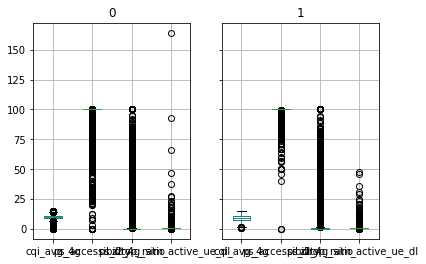

In [12]:
grouped = temp2.groupby('underdimensioned_hour')
grouped.boxplot(column = ['cqi_avg_4g','ps_accessibility','ps_drop_ratio','z2_4g_sim_active_ue_dl'])

Check if this 'cqi_avg_4g' feature is critical for the underdimension issue

In [219]:
grouped.count() 

,active_ue_dl_4g,active_ue_ul_4g,connected_user_avg,connected_user_max,cqi_avg_4g,duration_ul_s_4g,cell_id_hashed,prb_dl_utilization_4g,prb_ul_utilization_4g,ps_accessibility,...,hour_18,hour_19,hour_20,hour_21,hour_22,hour_23,system_LTE1800,system_LTE2600,system_LTE700,system_LTE800
underdimensioned_hour,,,,,,,,,,,,,,,,,,,,,
0,2014703,2014703,2014703,2014703,1099146,2014703,2014703,2014695,2014695,2004501,...,2014703,2014703,2014703,2014703,2014703,2014703,2014703,2014703,2014703,2014703
1,22461,22461,22461,22461,8208,22461,22461,22461,22461,21190,...,22461,22461,22461,22461,22461,22461,22461,22461,22461,22461


In [220]:
temp3 = temp2.dropna(subset=['cqi_avg_4g'])
grouped_without_cqi = temp3.groupby('underdimensioned_hour')
grouped_without_cqi.count()

,active_ue_dl_4g,active_ue_ul_4g,connected_user_avg,connected_user_max,cqi_avg_4g,duration_ul_s_4g,cell_id_hashed,prb_dl_utilization_4g,prb_ul_utilization_4g,ps_accessibility,...,hour_18,hour_19,hour_20,hour_21,hour_22,hour_23,system_LTE1800,system_LTE2600,system_LTE700,system_LTE800
underdimensioned_hour,,,,,,,,,,,,,,,,,,,,,
0,1099146,1099146,1099146,1099146,1099146,1099146,1099146,1099146,1099146,1095509,...,1099146,1099146,1099146,1099146,1099146,1099146,1099146,1099146,1099146,1099146
1,8208,8208,8208,8208,8208,8208,8208,8208,8208,7722,...,8208,8208,8208,8208,8208,8208,8208,8208,8208,8208


There is no change in the number of underdimensioned_hour before and after removing the rows with Null in 'cqi_avg_4g'

Thus, I decided to dump this feature, and fill the rest with their median values each

In [337]:
temp2 = temp2.drop('cqi_avg_4g',axis=1)
temp2[['prb_dl_utilization_4g','prb_ul_utilization_4g','ps_accessibility','ps_drop_ratio','z2_4g_sim_active_ue_dl']] = \
temp2[['prb_dl_utilization_4g','prb_ul_utilization_4g','ps_accessibility','ps_drop_ratio','z2_4g_sim_active_ue_dl']].\
fillna(temp2[['prb_dl_utilization_4g','prb_ul_utilization_4g','ps_accessibility','ps_drop_ratio','z2_4g_sim_active_ue_dl']].median())

In [338]:
print(temp2.isnull().sum())
print(temp2.shape)

active_ue_dl_4g                        0
active_ue_ul_4g                        0
connected_user_avg                     0
connected_user_max                     0
duration_ul_s_4g                       0
cell_id_hashed                         0
prb_dl_utilization_4g                  0
prb_ul_utilization_4g                  0
ps_accessibility                       0
ps_attempt                             0
ps_dl_mb                               0
ps_drop_ratio                          0
ps_ul_mb                               0
site_id_hashed                         0
transferred_data_ul_mb_4g              0
z1_4g_suc_att_erab                     0
z2_4g_sim_active_ue_dl                 0
underdimensioned_hour                  0
throughput_mbit_per_second_per_user    0
hour_0                                 0
hour_1                                 0
hour_2                                 0
hour_3                                 0
hour_4                                 0
hour_5          

In [339]:
temp2.head()

,active_ue_dl_4g,active_ue_ul_4g,connected_user_avg,connected_user_max,duration_ul_s_4g,cell_id_hashed,prb_dl_utilization_4g,prb_ul_utilization_4g,ps_accessibility,ps_attempt,...,hour_18,hour_19,hour_20,hour_21,hour_22,hour_23,system_LTE1800,system_LTE2600,system_LTE700,system_LTE800
0,0.000015,0.000079,0.001389,1.0,0.0,4962646669732964403,0.645609,0.000321,100.0,1.0,...,0,0,0,0,0,0,0,1,0,0
1,0.000473,0.000729,0.036111,2.0,0.0,4962646669732964403,0.679367,0.004582,100.0,8.0,...,0,0,0,0,0,0,0,1,0,0
6,0.000781,0.001492,0.147222,2.0,0.0,4962646669732964403,1.016763,0.024918,100.0,17.0,...,0,0,0,0,0,0,0,1,0,0
7,0.008470,0.013564,0.684722,6.0,10.0,4962646669732964403,2.148440,0.121654,100.0,124.0,...,0,0,0,0,0,0,0,1,0,0
8,0.004484,0.011153,0.352778,6.0,21.0,4962646669732964403,1.264922,0.391138,100.0,66.0,...,0,0,0,0,0,0,0,1,0,0


In [340]:
#random forest
X=temp2.drop(['cell_id_hashed','site_id_hashed','underdimensioned_hour','throughput_mbit_per_second_per_user'], axis = 1) # Features
y=temp2['underdimensioned_hour']  # Labels

# Split dataset into training set and test set
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3) # 70% training and 30% test
clf=RandomForestClassifier(n_estimators=50)
#try different criterion

scores = cross_val_score(clf, X, y, cv=5)
clf.fit(X,y)
#y_pred=clf.predict(X_test)
#print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
print(scores)

[0.99015298 0.99012844 0.99014316 0.99003272 0.99006215]


In [ ]:
[0.98994927 0.98989282 0.98988791 0.98982164 0.98977253]

Repeat the same processes for nsn data samples.

In [341]:
print(nsn['country_short'].unique())
print(nsn['municipality'].unique())
print(nsn['municipality_code'].unique())
print(nsn['technology'].unique())
print(nsn['brand'].unique())

['SE']
['GÖTEBORG']
[1480]
['4g']
['nsn']


In [342]:
nsn1 = nsn.drop(['Unnamed: 0','date','country_short','municipality', 'municipality_code', 'technology', 'brand'], axis = 1)
nsn1

,active_ue_dl_4g,active_ue_ul_4g,connected_user_avg,connected_user_max,cqi_avg_4g,duration_ul_s_4g,cell_id_hashed,hour,prb_dl_utilization_4g,prb_ul_utilization_4g,ps_accessibility,ps_attempt,ps_dl_mb,ps_drop_ratio,ps_ul_mb,site_id_hashed,system,transferred_data_ul_mb_4g,z1_4g_suc_att_erab,z2_4g_sim_active_ue_dl
0,0.004027,0.001770,0.15,2.0,8.479595,4.587,-1999078364597734729,0,0.675,0.050,100.0,62.0,38.41,0.0,1.11,-9008416214644696527,LTE2600,5.264192,62.0,1.000
1,0.004380,0.007893,0.08,1.0,8.497743,27.700,-1999078364597734729,1,0.675,0.050,100.0,36.0,39.07,0.0,0.92,-9008416214644696527,LTE2600,6.700768,36.0,1.000
2,0.009574,0.003796,1.59,7.0,10.671611,9.106,-1999078364597734729,2,0.600,0.175,100.0,777.0,43.97,0.0,2.04,-9008416214644696527,LTE2600,9.627432,777.0,1.000
3,0.015407,0.007735,1.56,6.0,10.849590,21.909,-1999078364597734729,3,1.075,0.325,100.0,722.0,157.30,0.0,4.02,-9008416214644696527,LTE2600,22.977768,722.0,1.000
4,0.006095,0.003384,1.11,5.0,10.802322,9.501,-1999078364597734729,4,0.425,0.150,100.0,542.0,6.11,0.0,1.33,-9008416214644696527,LTE2600,6.645560,542.0,1.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
816418,0.000471,0.000156,0.62,3.0,9.773519,0.416,-1999078364597734729,0,0.400,0.000,100.0,64.0,0.31,0.0,0.11,-9008416214644696527,LTE2600,0.371440,64.0,1.000
816419,0.000550,0.000451,0.34,2.0,10.676413,1.225,-1999078364597734729,1,0.400,0.000,100.0,66.0,0.80,0.0,0.56,-9008416214644696527,LTE2600,3.380664,66.0,1.000
816420,0.074401,0.001728,3.19,6.0,10.844442,3.484,-1999078364597734729,2,0.400,0.450,100.0,371.0,1.23,0.0,0.67,-9008416214644696527,LTE2600,2.153296,371.0,1.010
816421,0.071449,0.001892,2.99,7.0,11.048321,4.527,-1999078364597734729,3,0.425,0.325,100.0,411.0,10.66,0.0,0.81,-9008416214644696527,LTE2600,2.901040,411.0,1.015


In [343]:
hour_dummies_nsn = pd.get_dummies(nsn1.hour, prefix='hour')
system_dummies_nsn = pd.get_dummies(nsn1.system, prefix='system')
nsn1 = nsn1.drop(['hour','system'], axis = 1)
nsn1

,active_ue_dl_4g,active_ue_ul_4g,connected_user_avg,connected_user_max,cqi_avg_4g,duration_ul_s_4g,cell_id_hashed,prb_dl_utilization_4g,prb_ul_utilization_4g,ps_accessibility,ps_attempt,ps_dl_mb,ps_drop_ratio,ps_ul_mb,site_id_hashed,transferred_data_ul_mb_4g,z1_4g_suc_att_erab,z2_4g_sim_active_ue_dl
0,0.004027,0.001770,0.15,2.0,8.479595,4.587,-1999078364597734729,0.675,0.050,100.0,62.0,38.41,0.0,1.11,-9008416214644696527,5.264192,62.0,1.000
1,0.004380,0.007893,0.08,1.0,8.497743,27.700,-1999078364597734729,0.675,0.050,100.0,36.0,39.07,0.0,0.92,-9008416214644696527,6.700768,36.0,1.000
2,0.009574,0.003796,1.59,7.0,10.671611,9.106,-1999078364597734729,0.600,0.175,100.0,777.0,43.97,0.0,2.04,-9008416214644696527,9.627432,777.0,1.000
3,0.015407,0.007735,1.56,6.0,10.849590,21.909,-1999078364597734729,1.075,0.325,100.0,722.0,157.30,0.0,4.02,-9008416214644696527,22.977768,722.0,1.000
4,0.006095,0.003384,1.11,5.0,10.802322,9.501,-1999078364597734729,0.425,0.150,100.0,542.0,6.11,0.0,1.33,-9008416214644696527,6.645560,542.0,1.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
816418,0.000471,0.000156,0.62,3.0,9.773519,0.416,-1999078364597734729,0.400,0.000,100.0,64.0,0.31,0.0,0.11,-9008416214644696527,0.371440,64.0,1.000
816419,0.000550,0.000451,0.34,2.0,10.676413,1.225,-1999078364597734729,0.400,0.000,100.0,66.0,0.80,0.0,0.56,-9008416214644696527,3.380664,66.0,1.000
816420,0.074401,0.001728,3.19,6.0,10.844442,3.484,-1999078364597734729,0.400,0.450,100.0,371.0,1.23,0.0,0.67,-9008416214644696527,2.153296,371.0,1.010
816421,0.071449,0.001892,2.99,7.0,11.048321,4.527,-1999078364597734729,0.425,0.325,100.0,411.0,10.66,0.0,0.81,-9008416214644696527,2.901040,411.0,1.015


In [344]:
nsn2 = pd.concat([nsn1, hour_dummies_nsn, system_dummies_nsn], axis=1)
nsn2

,active_ue_dl_4g,active_ue_ul_4g,connected_user_avg,connected_user_max,cqi_avg_4g,duration_ul_s_4g,cell_id_hashed,prb_dl_utilization_4g,prb_ul_utilization_4g,ps_accessibility,...,hour_18,hour_19,hour_20,hour_21,hour_22,hour_23,system_LTE1800,system_LTE2600,system_LTE700,system_LTE800
0,0.004027,0.001770,0.15,2.0,8.479595,4.587,-1999078364597734729,0.675,0.050,100.0,...,0,0,0,0,0,0,0,1,0,0
1,0.004380,0.007893,0.08,1.0,8.497743,27.700,-1999078364597734729,0.675,0.050,100.0,...,0,0,0,0,0,0,0,1,0,0
2,0.009574,0.003796,1.59,7.0,10.671611,9.106,-1999078364597734729,0.600,0.175,100.0,...,0,0,0,0,0,0,0,1,0,0
3,0.015407,0.007735,1.56,6.0,10.849590,21.909,-1999078364597734729,1.075,0.325,100.0,...,0,0,0,0,0,0,0,1,0,0
4,0.006095,0.003384,1.11,5.0,10.802322,9.501,-1999078364597734729,0.425,0.150,100.0,...,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
816418,0.000471,0.000156,0.62,3.0,9.773519,0.416,-1999078364597734729,0.400,0.000,100.0,...,0,0,0,0,0,0,0,1,0,0
816419,0.000550,0.000451,0.34,2.0,10.676413,1.225,-1999078364597734729,0.400,0.000,100.0,...,0,0,0,0,0,0,0,1,0,0
816420,0.074401,0.001728,3.19,6.0,10.844442,3.484,-1999078364597734729,0.400,0.450,100.0,...,0,0,0,0,0,0,0,1,0,0
816421,0.071449,0.001892,2.99,7.0,11.048321,4.527,-1999078364597734729,0.425,0.325,100.0,...,0,0,0,0,0,0,0,1,0,0


In [345]:
print(nsn2.isnull().sum())

active_ue_dl_4g              26000
active_ue_ul_4g              26000
connected_user_avg           25953
connected_user_max           25953
cqi_avg_4g                   38320
duration_ul_s_4g             24860
cell_id_hashed                   0
prb_dl_utilization_4g        24920
prb_ul_utilization_4g        24919
ps_accessibility             34568
ps_attempt                   34593
ps_dl_mb                     24919
ps_drop_ratio                47860
ps_ul_mb                     24919
site_id_hashed                   0
transferred_data_ul_mb_4g    24860
z1_4g_suc_att_erab           34593
z2_4g_sim_active_ue_dl       26000
hour_0                           0
hour_1                           0
hour_2                           0
hour_3                           0
hour_4                           0
hour_5                           0
hour_6                           0
hour_7                           0
hour_8                           0
hour_9                           0
hour_10             

In [346]:
nsn2 = nsn2.drop('cqi_avg_4g',axis=1)
nsn2[['active_ue_dl_4g','active_ue_ul_4g','connected_user_avg','connected_user_max','duration_ul_s_4g',\
      'prb_dl_utilization_4g','prb_ul_utilization_4g','ps_accessibility','ps_attempt','ps_dl_mb','ps_drop_ratio',\
      'ps_ul_mb','transferred_data_ul_mb_4g','z1_4g_suc_att_erab','z2_4g_sim_active_ue_dl']] = \
nsn2[['active_ue_dl_4g','active_ue_ul_4g','connected_user_avg','connected_user_max','duration_ul_s_4g',\
      'prb_dl_utilization_4g','prb_ul_utilization_4g','ps_accessibility','ps_attempt','ps_dl_mb','ps_drop_ratio',\
      'ps_ul_mb','transferred_data_ul_mb_4g','z1_4g_suc_att_erab','z2_4g_sim_active_ue_dl']].\
fillna(nsn2[['active_ue_dl_4g','active_ue_ul_4g','connected_user_avg','connected_user_max','duration_ul_s_4g',\
      'prb_dl_utilization_4g','prb_ul_utilization_4g','ps_accessibility','ps_attempt','ps_dl_mb','ps_drop_ratio',\
      'ps_ul_mb','transferred_data_ul_mb_4g','z1_4g_suc_att_erab','z2_4g_sim_active_ue_dl']].median())

In [347]:
print(nsn2.isnull().sum())
print(nsn2.shape)

active_ue_dl_4g              0
active_ue_ul_4g              0
connected_user_avg           0
connected_user_max           0
duration_ul_s_4g             0
cell_id_hashed               0
prb_dl_utilization_4g        0
prb_ul_utilization_4g        0
ps_accessibility             0
ps_attempt                   0
ps_dl_mb                     0
ps_drop_ratio                0
ps_ul_mb                     0
site_id_hashed               0
transferred_data_ul_mb_4g    0
z1_4g_suc_att_erab           0
z2_4g_sim_active_ue_dl       0
hour_0                       0
hour_1                       0
hour_2                       0
hour_3                       0
hour_4                       0
hour_5                       0
hour_6                       0
hour_7                       0
hour_8                       0
hour_9                       0
hour_10                      0
hour_11                      0
hour_12                      0
hour_13                      0
hour_14                      0
hour_15 

In [361]:
#random forest (no need to normalize the features and robust)
X_nsn= nsn2.drop(['cell_id_hashed','site_id_hashed'], axis = 1) # Features
cell_id = nsn2.cell_id_hashed#.to_numpy()
site_id = nsn2.site_id_hashed#.to_numpy()
y_nsn=clf.predict(X_nsn)

We have now obtained the inference results so attach them together and see the underdimensioned hours. 

In [362]:
y_nsn = np.transpose(y_nsn[None])
#cell_id = np.transpose(cell_id[None])
#site_id = np.transpose(site_id[None])
print(cell_id.shape, site_id.shape)
#result = np.concatenate((cell_id,site_id,y_nsn),axis=1)
print(np.unique(y_nsn, return_counts=True))

(816423,) (816423,)
(array([0, 1]), array([784454,  31969]))


In [363]:
df_y = pd.DataFrame(y_nsn, columns = ['underdimensioned_hour'])
df_result = pd.concat([cell_id, site_id, df_y], axis=1)

In [364]:
result_under = df_result[df_result['underdimensioned_hour'] == 1]
result_under

,cell_id_hashed,site_id_hashed,underdimensioned_hour
24,-2856917326595762184,-9008416214644696527,1
26,-2856917326595762184,-9008416214644696527,1
29,-2856917326595762184,-9008416214644696527,1
47,-2856917326595762184,-9008416214644696527,1
53,-2876663825384070500,-9008416214644696527,1
...,...,...,...
816393,-8337210388656249391,8185861896116851807,1
816394,-6305184101549858991,8185861896116851807,1
816395,-6305184101549858991,8185861896116851807,1
816396,-6305184101549858991,8185861896116851807,1


In [365]:
result_group = result_under.groupby(['site_id_hashed','cell_id_hashed']).count()
result_group.head(30)

underdimensioned_hour
site_id_hashed       cell_id_hashed                             
-9091200276681354862 -6896607774311414166                      1
                     -5222695339684283039                      1
                     -758939766565477311                       1
                      3420070866528684871                      6
-9008416214644696527 -8570325779602070641                     13
                     -7234916183056754394                     10
                     -2876663825384070500                     50
                     -2856917326595762184                     36
                     -1999078364597734729                      8
                      1594735512158349202                      1
                      2163814994250901038                      8
                      2514770240229998989                      6
-8938802510512189221 -6415894918572813587                      7
                     -4899981273522649254                     12
                     -4898009511350776465                      4
                     -2783660335449617937                      8
                     -1957929871072350964                     11
                      6070144099855742745                     18
-8915226986396368490 -5899431961121969633                      2
                     -3961196112984855185                      6
-8813905818436392380 -9152404908900954447                      6
                     -511599387792714574                      11
                      6747743508256274604                     11
-8765327780801344841 -2958351137695638046                     55
                      7545496229039361688                     38
-8695264933971315838 -4443917239606931480                      8
                     -2958356115208076421                     13
                     -927001539829063606                      99
                     -860533117809763030                     262
                     -210806214500434701                      35

In [366]:
result_sorted = result_group.sort_values(by=['underdimensioned_hour'],ascending=False)

In [367]:
result_sorted

,,underdimensioned_hour
site_id_hashed,cell_id_hashed,
-1275349721366665305,6802032146378489939,360
-3797912968133930386,6560888511135863767,357
431095361909790338,1741099901357259616,355
-1275349721366665305,-2621312853872116520,349
431095361909790338,4354094316821934518,346
...,...,...
-774368928776960159,-8298299300377777185,1
-885763662500209278,2795923897135513809,1
-955051988184143044,-220609031308411866,1


In [368]:
result_sorted.to_csv('nsn_inference.csv')